In [85]:
# 1. Import and define data processing functions
import csv
import numpy as NP
from collections import defaultdict
import pyBigWig
import pylab as PL
from bx.bbi.bigbed_file import BigBedFile

PL.rcParams.update({
    'font.family': 'Arial',  # Substitute with 'sans-serif' if Arial not available
    'font.size': 10,
    'axes.labelsize': 8,
    'axes.titlesize': 8,
    'axes.edgecolor': 'black',
    'axes.linewidth': 1.0,
    'xtick.color': 'black',
    'ytick.color': 'black',
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.major.size': 4,
    'ytick.major.size': 4,
    'legend.frameon': False,
    'figure.dpi': 300,
    'savefig.dpi': 300,
    'axes.grid': False,
    'grid.color': 'grey',
    'grid.linestyle': '--',
    'grid.linewidth': 0.5,
    'lines.linewidth': 1.5,
    'lines.markersize': 5,
    'figure.figsize': (3.5, 2.5),  # suitable for two-column journals
    'pdf.fonttype': 42,  # embed TrueType fonts (like Arial)
    'ps.fonttype': 42,
    'axes.prop_cycle': PL.cycler(color=[
        "#000000", "#E69F00", "#56B4E9", "#009E73",
        "#F0E442", "#0072B2", "#D55E00", "#CC79A7"
    ])  # Color Universal Design palette
})


""" """
def get_gene_decorations(gene_areas, decorations):
    result = {}
    # 1. regulatory
    regulatory_decorations = read_regulatory_locations()
    for g in gene_areas:
        (chrm, start, end) = gene_areas[g]
        result[g] = {}
        for k in regulatory_decorations:
            result[g][k] = []
            for (s,e) in regulatory_decorations[k][chrm]:
                if s < start and e > end:
                    result[g][k].append((start, end))
                elif s >= start and s < end:
                    result[g][k].append((s, min(e, end)))
                elif e >= start and e < end:
                    result[g][k].append((max(s,start), e))
    # 2. mirnas
    mirnas = read_mirnas()
    for gene in gene_areas:
        (chrm, start, end) = gene_areas[gene]
        if chrm is None: continue
        result[gene]["mirna"] = mirnas[chrm]
    
    # 3. encode ccre combined
    encode_bb = BigBedFile(open("encodeCcreCombined.bb", "rb"))
    n = 0
    for gene in gene_areas:
        (chrm, start, end) = gene_areas[gene]
        if chrm is None: continue
        for entry in encode_bb.get(chrm.encode(), int(start), int(end)):
            if entry[10] not in result[gene]: result[gene][entry[10]] = []
            result[gene][entry[10]].append((float(entry[1]), float(entry[2])))

    return result


def read_regulatory_locations(filepath="Homo_sapiens.GRCh38.regulatory_features.v114.gff3"):
    # Load the file as a structured numpy array
    data = NP.genfromtxt(filepath, dtype=None, encoding=None, delimiter='\t',
        usecols=(0, 2, 3, 4),  # 1st, 3rd, 4th, 5th columns
        names=('seqid', 'feature', 'start', 'end')
    )

    # Initialize nested dict: feature -> seqid -> list of [start, end]
    result = defaultdict(lambda: defaultdict(list))

    # Populate the structure
    for row in data:
        seqid = row['seqid']
        feature = row['feature']
        start = int(row['start'])
        end = int(row['end'])
        result[feature][seqid].append((start, end))

    return result

def get_gene_areas(map_meta, all_dels, header, surrounding=100):
    gene_areas = {}
    for gene in all_dels:
        gene_areas[gene] = [None, 1e9, 0]
        for del_type in all_dels[gene]:
            for oligo in all_dels[gene][del_type]:
                xs = map_meta[oligo][header.index("del_start")-1:header.index("del_end")] # slice the oligo target coordinates
                gene_areas[gene][0] = map_meta[oligo][header.index("chr")-1]
                if len(xs[0]) > 0:
                    gene_areas[gene][1] = min(float(xs[0])-surrounding, gene_areas[gene][1])
                if len(xs[1]) > 0:
                    gene_areas[gene][2] = max(float(xs[1])+surrounding, gene_areas[gene][2])
    return gene_areas


def read_oligo_features(filename="dunnock_counts_featurized_corecolumns_paper.csv"):
    map_meta = {}
    map_l2fc = {}
    map_len = {}
    map_gene = {}
    map_ess = {}
    map_gencode = {}
    oligo_i = {}


    with open(filename, newline='') as csvfile:
        reader = csv.reader(csvfile)
        header = next(reader)  # Skip the header row
        i = 0

        for row in reader:
            key = row[0]
            # Extract columns 2 to -5 (columns 1 to -5 in 0-indexed Python)
            map_meta[key] = row[1:]
            map_gene[key] = row[header.index("main_gene")] # real gene
            map_len[key] = int(row[header.index("del_length")])
            map_ess[key] = row[header.index("main_gene_essentiality")]
            map_gencode[key] = row[header.index("gencode_featurelist")]
            oligo_i[key] = i
            
            if map_ess[key] == '': map_ess[key] = NP.nan
            else: map_ess[key] = float(map_ess[key])
            if map_gencode[key] == '': map_gencode[key] = []
            else: map_gencode[key] = eval(map_gencode[key])
            vals = [float(x) for x in row[-3:] if x != '']
            
            # Extract the last four columns and convert to float for averaging
            if len(vals) > 0:
                map_l2fc[key] = sum(vals)/(1.*len(vals))
            else:
                map_l2fc[key] = NP.nan
            i += 1

    return map_meta, map_l2fc, map_len, map_gene, map_ess, map_gencode, oligo_i, header


# seqnames   start     end       strand  width   rank    gene    ensembl.gene.id
# 19         58353404  58353492  -       89      1       A1BG    ENSG00000121410
def read_exon_locations(filepath="HAP1.ranked.exons.with.utrs.tsv"):
    exons = defaultdict(list)
    with open(filepath) as f:
        for line in f:
            if line.startswith("seq"):
                continue
            parts = line.strip().split("\t")
            if len(parts) != 10:
                continue
            chrom, start, end, strand, leng, rank, gene, ensg, is5utr, is3utr = parts
            start, end = int(start), int(end)
            # Store full attribute string or parse as needed
            exons[f"chr{chrom}"].append((start, end, gene, is5utr, is3utr))
    
    # Sort each list of exons by start coordinate
    for chrom in exons:
        exons[chrom] = sorted(set(exons[chrom]))
    return exons


def get_gene_exons(gene, exons, utrcode="00"):
    gene_exons = []
    for chrm in exons:
        for (start, end, g, utr5, utr3) in exons[chrm]: 
            if g == gene and utr5 + utr3 == utrcode: 
                gene_exons.append([start,end])
    return gene_exons


def _get_gene_chrm(gene, exons):
    for chrm in exons:
        for (start, end, g, utr5, utr3) in exons[chrm]: 
            if g == gene: return chrm
    return None


def does_overlap(s1, s2): # do 2 segments overlap?
    a,b = s1
    x,y = s2
    if a < x and b > y: return True # x,y within a,b
    elif a >= x and a < y: return True # start within x,y
    elif b >= x and b < y: return True # end within x,y
    return False # neither end within x,y, also not encompassing - no overlap



""" Return: 1) coding deletions 2) intronic deletions 3) 5'utr deletions 4) 3'utr deletions 5) other deletions within 50kb """
def get_gene_deletion_oligos(gene, exons, map_meta, surrounding=5000): # get all deletions overlapping the gene (from exon annotations)
    minx = 1e9
    maxx = 0
    gene_chrm = _get_gene_chrm(gene, exons)
    gene_exons = get_gene_exons(gene, exons, "00")
    utrs5 = get_gene_exons(gene, exons, "10")
    utrs3 = get_gene_exons(gene, exons, "01")
    minx, maxx, mincoding, maxcoding = None, None, None, None
    if len(gene_exons+utrs5+utrs3) > 0:
        minx = min([min(x,y) for (x,y) in gene_exons+utrs5+utrs3])
        maxx = max([max(x,y) for (x,y) in gene_exons+utrs5+utrs3])
    if len(gene_exons) > 0:
        mincoding = min([min(x,y) for (x,y) in gene_exons])
        maxcoding = max([max(x,y) for (x,y) in gene_exons])
    dels = {"Coding":[], "Intronic":[], "3'UTR":[], "5'UTR":[], "Other": []}

    oligos = [k for k in map_meta]
    for i in range(len(oligos)):
        k = oligos[i]
        if map_meta[k][header.index("chr") - 1] != gene_chrm: 
            continue
        xs = list(map(float, map_meta[k][header.index("del_start")-1:header.index("del_end")])) # slice the oligo target coordinates
        overlap = None

        # From more lenient to less lenient: 
        if (minx is not None) and does_overlap(xs, [minx-surrounding, maxx+surrounding]): # any surrounding region
            overlap = "Other"
        for exon in utrs3: # 3' UTR
            if does_overlap(xs, exon):
                overlap = "3'UTR"
        for exon in utrs5: # 5' UTR
            if does_overlap(xs, exon):
                overlap = "5'UTR"
        if (mincoding is not None) and does_overlap(xs, [mincoding, maxcoding]): # anything between first and last coding exons
            overlap = "Intronic"
        for exon in gene_exons: # overlapping coding exon
            if does_overlap(xs, exon):
                overlap = "Coding"

        if overlap is not None:
            dels[overlap].append(k)
    return dels


def remove_overlaps(gene_dels, gene_chrm):
    all_genes = [g for g in gene_dels]
    for g1 in range(len(all_genes)):
        for g2 in range(len(all_genes)):
            gene1, gene2 = all_genes[g1], all_genes[g2]
            c1, c2 = gene_chrm[gene1], gene_chrm[gene2]
            if c1 != c2: 
                continue

            # remove gene 2 non-other deletions from gene 1 "other"
            for k in gene_dels[gene2]:
                if k != "Other":
                    gene_dels[gene1]["Other"] = list(set(gene_dels[gene1]["Other"]) - set(gene_dels[gene2][k]))
    return gene_dels


def read_gene_chrm(header, map_meta):
    gene_chrm = {}
    i_gene1 = header.index("gene_name") - 1
    i_gene2 = header.index("main_gene") - 1
    i_chrm = header.index("chr") - 1
    for k in map_meta:
        gene_chrm[map_meta[k][i_gene1]] = map_meta[k][i_chrm]
        gene_chrm[map_meta[k][i_gene2]] = map_meta[k][i_chrm]
    return gene_chrm


def compute_dels(gene_ess, exons, map_meta, gene_chrm, do_plot=True):
    all_dels = {}
    coding_counts, total_counts = [], []
    for gene in gene_ess:
        gene_dels = get_gene_deletion_oligos(gene, exons, map_meta, 5000)
        n_coding = len(gene_dels["Coding"])
        n_total = sum([len(gene_dels[t]) for t in gene_dels])
        coding_counts.append(n_coding)
        total_counts.append(n_total)
        all_dels[gene] = get_gene_deletion_oligos(gene, exons, map_meta, 5000)

    if do_plot:
        PL.figure(None, [4,4])
        PL.subplot(211)
        PL.hist(NP.log2(NP.array(coding_counts)+1), range=(0,7), bins=14)
        PL.axvline(NP.log2(3+1), color='r')
        PL.xlabel("log2(# coding dels)"); PL.ylabel("# genes")
        PL.subplot(212)
        PL.hist(NP.log2(NP.array(total_counts)+1), range=(0,7), bins=14)
        PL.axvline(NP.log2(7+1), color='r')
        PL.xlabel("log2(#all dels)"); PL.ylabel("# genes")
        PL.tight_layout()

    all_dels = remove_overlaps(all_dels, gene_chrm)

    to_remove = []
    for gene in all_dels:
        n_coding = len(all_dels[gene]["Coding"])
        n_total = sum([len(all_dels[gene][t]) for t in gene_dels])
        if n_coding < 3 or n_total < 7:
            to_remove.append(gene)
    for gene in to_remove: all_dels.pop(gene)
    return all_dels

def compute_all_lfcs(all_dels, map_l2fc):
    all_lfcs = {}
    for gene in all_dels:
        all_lfcs[gene] = {}
        for del_type in all_dels[gene]:
            all_lfcs[gene][del_type] = [map_l2fc[k] for k in all_dels[gene][del_type]]
    return all_lfcs

def compute_coding_length(header, map_gene, exons, map_meta):
    i1, i2 = header.index("del_start") - 1, header.index("del_end") - 1
    coding_deletion_length = {}

    for gene in sorted(set(map_gene.values())):
        gene_exons = get_gene_exons(gene, exons)
        for k in map_meta:
            if map_meta[k][i1] == "": continue # skip non-genomic targets

            if map_gene[k] == gene:
                mm = NP.array(map_meta[k])
                d1, d2, = int(float(mm[i1])), int(float(mm[i2])) # mm[5] is gene strand if needed
                coding_length = 0
                for (x1, x2) in gene_exons:
                    if x1 >= d1: # exon starts after start of deletion
                        if x1 <= d2: # exon starts in middle of deletion
                            coding_length += (1 + min(d2-x1, x2-x1))
                        else:
                            pass # x1 > d2: no overlap
                    else: # exon starts before deletion
                        if x2 >= d1: # exon ends after start of deletion
                            coding_length += (1 + min(x2-d1, d2-d1))
                        else:
                            pass # x2 < d1: no overlap
                coding_deletion_length[k] = coding_length
    return coding_deletion_length


def read_mirnas(filepath="hsa_mirnas.gff3"):
    # Load the file as a structured numpy array
    data = NP.genfromtxt(filepath, dtype=None, encoding=None, delimiter='\t', skip_header=10,
        usecols=(0, 3, 4),  # 1st, 4th, 5th columns
        names=('seqid', 'start', 'end')
    )

    # Initialize nested dict: feature -> seqid -> list of [start, end]
    result = defaultdict(list)

    # Populate the structure
    for row in data:
        seqid = row['seqid']
        start = int(row['start'])
        end = int(row['end'])
        result[seqid].append((start, end))

    return result



# add splice regions: 100 nt downstream of donor, 200nt upstream of acceptor
def get_exon_splice_regions(exons, strand, donor_span=100, acceptor_span=200):
    splice_regions = []

    if strand == "+":
        for (x1,x2) in exons:
            splice_regions.append((x1-acceptor_span, x1))
            splice_regions.append((x2, x2 + donor_span))
    else:
        for (x1,x2) in exons:
            splice_regions.append((x1-donor_span, x1))
            splice_regions.append((x2, x2 + acceptor_span))
            
    return splice_regions


def get_max_expr(chrm, regions, filename="RNAseq_HAP1_c12_R1.bw"):
    result = 0
    bw = pyBigWig.open(filename)
    for (x1, x2) in regions:
        coverage = bw.values(chrm, x1, x2, numpy=True)
        for v in coverage:
            if v is not None: result = max(result, NP.log2(v))

    return result


def get_rnaseq_coverage(chrm, x1, x2, filename="RNAseq_HAP1_c12_R1.bw", do_normalize=True):
    bw = pyBigWig.open(filename)
    coverage = bw.values(chrm, x1, x2, numpy=True)
    x = NP.array(range(x1, x2))
    y = NP.log2(NP.array([v if v is not None else 0 for v in coverage], float) + 1)
    if do_normalize:
        y = y/(NP.nanmax(y)+1e-10)
    return y



In [9]:
# 2. Define plotting functions
def _plot_coverage(chrm, x1, x2, filename="RNAseq_HAP1_c12_R1.bw"):
    bw = pyBigWig.open(filename)
    coverage = bw.values(chrm, x1, x2, numpy=True)
    x = NP.array(range(x1, x2))
    y = NP.log2(NP.array([v if v is not None else 0 for v in coverage], float) + 1)
    y = y/(NP.nanmax(y)+1e-10)
    PL.plot(x[~NP.isnan(y)], y[~NP.isnan(y)], color='orange', lw=0.5, alpha=1)
    PL.plot([x1,x2], [0,0], color='k', lw=0.2, linestyle='dashed')
    PL.plot([x1,x2], [1,1], color='k', lw=0.2, linestyle='dashed')


def plot_target_gene(gene, all_dels, map_l2fc, map_meta, map_gene, gene_exons, gene_utrs, header, decorations=None, filename=None, title=None, maxy=1, miny=-3):    
    minx, maxx, minexonx, maxexonx, gene_chrm = 1e9, 0, 1e9, 0, None

    # 1. Plot oligo values
    PL.figure(None, [5,2])
    if title is None: title = gene

    colors = {'Coding': 'r', 'Intronic': 'y', "5'UTR":'g', "3'UTR":'g', "Other":'k'}
    alphas = {'Coding': 0.8, 'Intronic': 1, "5'UTR": 0.7, "3'UTR":0.5, "Other":0.2}

    dels = all_dels[gene]
    lfcs = {}
    for del_type in dels:
        xs = NP.array([map_meta[k][header.index("del_start")-1:header.index("del_end")] for k in dels[del_type]]) # slice the oligo target coordinates
        ys = [min(maxy, max(miny, map_l2fc[k])) for k in dels[del_type]] # get oligo LFCs, clip to between +3 and -5
        lfcs[del_type] = ys

        for i in range(len(xs)):
            color = colors[del_type]
            alpha = alphas[del_type]
            linewidth = 1
            border = "none"
            if del_type == "Coding" and ys[i] <= -1: linewidth=2
            PL.plot(NP.array(xs[i],float), [ys[i], ys[i]], color+"-", alpha=alpha, linewidth=linewidth)
            minx = min(minx, min(float(xs[i][0]), float(xs[i][1])))
            maxx = max(maxx, max(float(xs[i][0]), float(xs[i][1])))
            if del_type != "Other":
                minexonx = min(minexonx, min(float(xs[i][0]), float(xs[i][1])))
                maxexonx = max(maxexonx, max(float(xs[i][0]), float(xs[i][1])))
            gene_chrm = map_meta[dels[del_type][i]][header.index('chr')-1]
    # 2. Plot exon locations
    for (x1,x2) in gene_exons: 
        if x1 < maxexonx and x2 > minexonx:
            PL.axvspan(x1, x2, color='grey', alpha=0.2, edgecolor='none', linewidth=0)
    for (x1,x2) in gene_utrs: 
        if x1 < maxx and x2 > minx:
            PL.axvspan(x1, x2, color='green', alpha=0.1, edgecolor='none', linewidth=0)
    # 3. Plot decorations
    track_colors = {'promoter':'g', 'enhancer':'m', 'CTCF_binding_site':'c', 'open_chromatin_region':'y'}
    track_alphas = {'promoter':0.3, 'enhancer':0.1, 'CTCF_binding_site':0.2, 'open_chromatin_region':0.1}
    if decorations is not None:
        for track in decorations[gene]:
            for (x1, x2) in decorations[gene][track]:
                if x1 > maxx or x2 < minx: 
                    continue
                if track == "CTCF_binding_site":
                    PL.axvline(0.5*(x1+x2), color=track_colors[track], alpha=track_alphas[track])
                else:
                    PL.axvspan(x1, x2, color=track_colors[track], alpha=track_alphas[track], edgecolor='none', linewidth=0)
    # 4. Plot RNAseq coverage
    _plot_coverage(gene_chrm, int(minexonx), int(maxexonx))
    PL.plot([int(minx), int(maxx)],[-1,-1], 'k--', linewidth=0.8)
    PL.tight_layout()
    print(f"{gene}: Exonic={NP.nanmedian(lfcs['Coding']):.2f} Non-coding={NP.nanmedian(lfcs['Intronic']):.2f} Delta={NP.nanmedian(lfcs['Coding'])-NP.nanmedian(lfcs['Intronic']):.2f}")
    PL.ylim(1.1*miny, 1.1*maxy)
    oth = NP.array(lfcs["Other"])
    p = 0.5
    from scipy.stats import fisher_exact
    pval1 = fisher_exact([[sum(oth>=0), sum(oth<0)],[p*len(oth), (1-p)*len(oth)]], alternative='greater')[1] # treat, control
    pval2 = fisher_exact([[sum(oth>=0), sum(oth<0)],[p*len(oth), (1-p)*len(oth)]], alternative='less')[1] # treat, control
    PL.title(title + f" median(exon)={NP.nanmedian(lfcs['Coding']):.2f}" + f" median(other)={NP.nanmedian(lfcs['Other']):.2f}; p={pval1:1.4f} {pval2:1.4f}")
    return lfcs


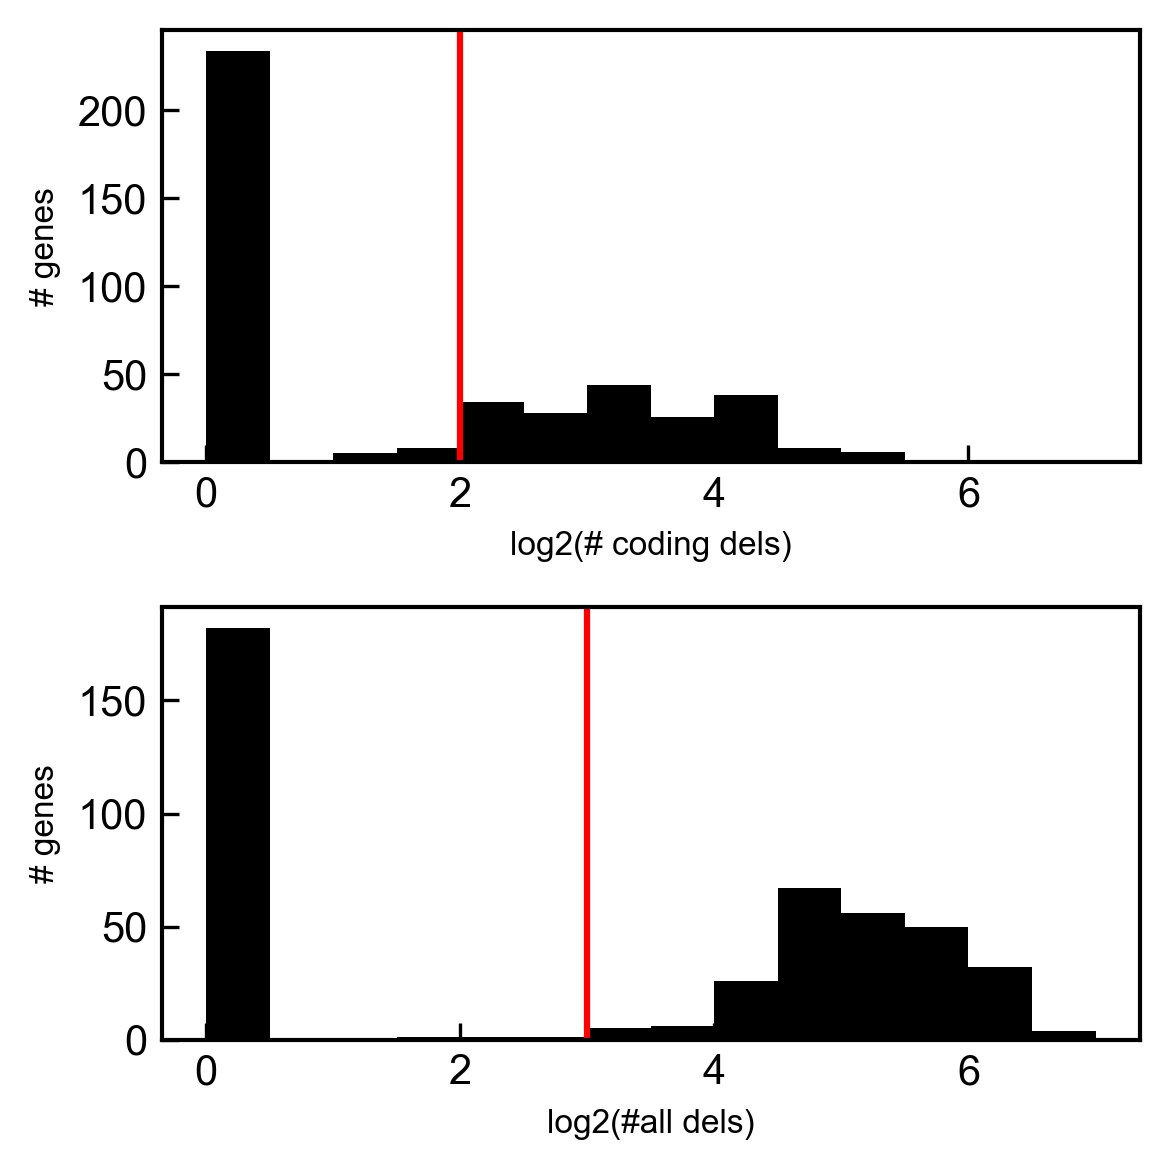

In [45]:
# 3. Calculate main statistics and summaries; populate common variables
exons = read_exon_locations()
map_meta, map_l2fc, map_len, map_gene, map_ess, map_gencode, oligo_i, header = read_oligo_features()
gene_ess = {map_gene[k]: map_ess[k] for k in map_ess}
gene_chrm = read_gene_chrm(header, map_meta)
all_dels = compute_dels(gene_ess, exons, map_meta, gene_chrm)
all_lfcs = compute_all_lfcs(all_dels, map_l2fc)

essential_genes = [g for g in gene_ess if gene_ess[g] < -1 and g not in ["POLG2", "EIF4G1", "EIF4B"] and g in all_lfcs]
nonessential_genes = [g for g in gene_ess if gene_ess[g] > -0.25 and g not in ["POLG2", "EIF4G1", "EIF4B"] and g in all_lfcs]

clean_essential_oligos = []
for g in all_dels:
    if g in essential_genes: 
        clean_essential_oligos.extend(all_dels[g]["Coding"])


[T]he majority of such deletions were depleted (LFC < -1; 72%, 724/1003; Figure 4f)


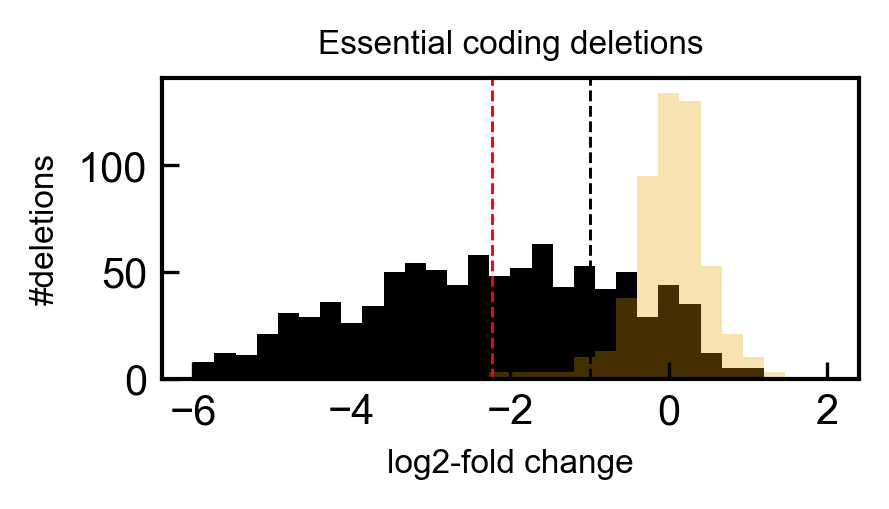

In [34]:
# 4.1 Dropout of essential gene exon deletions
essential_coding_lfcs, nonessential_coding_lfcs = [], []
for g in essential_genes: essential_coding_lfcs.extend(all_lfcs[g]["Coding"])
for g in nonessential_genes: nonessential_coding_lfcs.extend(all_lfcs[g]["Coding"])
essential_coding_lfcs, nonessential_coding_lfcs = NP.array(essential_coding_lfcs), NP.array(nonessential_coding_lfcs)
N = len(essential_coding_lfcs)
N1 = sum(essential_coding_lfcs <= -1)

PL.figure(None, [3,1.3])
PL.hist(essential_coding_lfcs, range=[-6,2], bins=30)
PL.axvline(NP.nanmedian(essential_coding_lfcs), color='r', linewidth=0.7, linestyle='dashed')
PL.axvline(-1, color='k', linewidth=0.7, linestyle='dashed')
PL.hist(nonessential_coding_lfcs, range=[-6,2], bins=30, alpha=0.3)
PL.xlabel("log2-fold change"); PL.ylabel("#deletions"); PL.title("Essential coding deletions")
print(f"[T]he majority of such deletions were depleted (LFC < -1; {int(100.*N1/N)}%, {N1}/{N}; Figure 4f)")


The per-gene fraction of depleted exon deletions was 0.76 on average (Figure 5b)


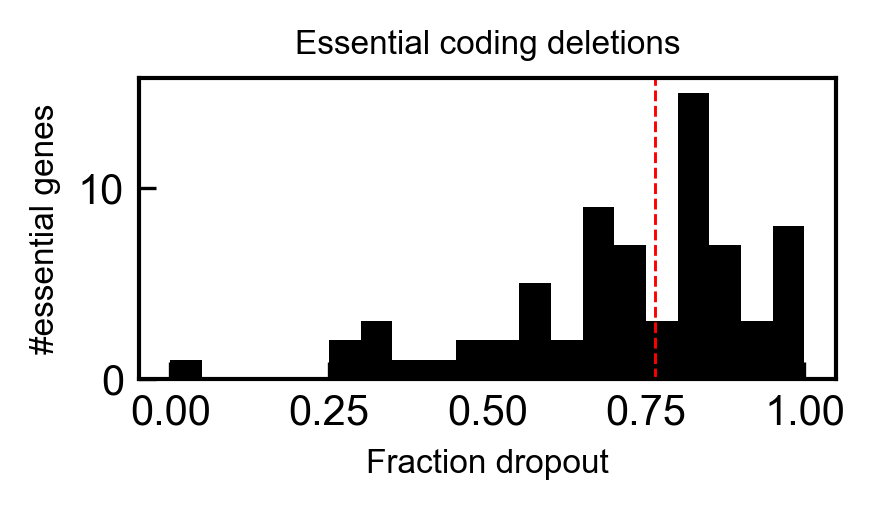

In [35]:
# 4.2 Per essential gene fraction dropout
coding_med = {g: NP.nanmedian(all_lfcs[g]["Coding"]) for g in all_lfcs if len(all_lfcs[g]["Coding"]) >= 3}
frac_dropout = {g: 1.*NP.sum(NP.array(all_lfcs[g]["Coding"]) < -1)/len(all_lfcs[g]["Coding"]) for g in all_lfcs if len(all_lfcs[g]["Coding"]) >= 3}
median_dropout = NP.nanmedian([frac_dropout[g] for g in essential_genes if g in frac_dropout])

PL.figure(None, [3,1.3])
PL.hist([frac_dropout[g] for g in essential_genes if g in frac_dropout], range=[0,1], bins=20)
PL.axvline(median_dropout, color='r', linewidth=0.7, linestyle='dashed')
PL.xlabel("Fraction dropout"); PL.ylabel("#essential genes"); PL.title("Essential coding deletions")
print(f"The per-gene fraction of depleted exon deletions was {median_dropout:.2} on average (Figure 5b)")

[Dropout fraction is] correlated with gene essentiality estimated in a CRISPR knockout screen (Pearson’s R=-0.79)


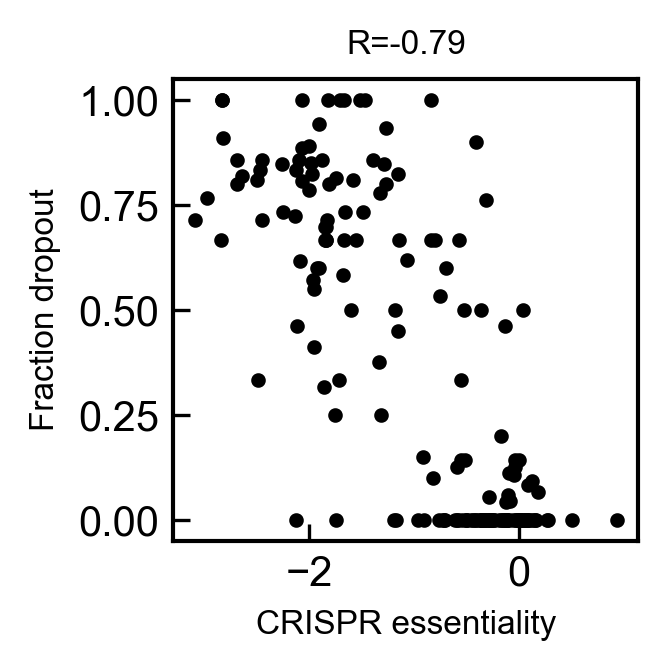

In [44]:
# 4.3 Essential gene coding deletion dropout rate correlation with CRISPR screen
x = NP.array([gene_ess[g] for g in frac_dropout if g in gene_ess and len(all_lfcs[g]["Coding"]) >= 3])
y = NP.array([frac_dropout[g] for g in frac_dropout if g in gene_ess and len(all_lfcs[g]["Coding"]) >= 3])
I = NP.isnan(x) | NP.isnan(y)
r = NP.corrcoef(x[~I],y[~I])[0,1]

PL.figure(None, [2,2])
PL.plot(x,y, ".")
PL.xlabel("CRISPR essentiality"); PL.ylabel("Fraction dropout")
PL.title(f"R={r:.2}")

print(f"[Dropout fraction is] correlated with gene essentiality estimated in a CRISPR knockout screen (Pearson’s R={r:.2})")

If a deletion was depleted, 68% of other deletions that overlapped it were depleted (759/1115 possible pairs concordant; Figure S8)


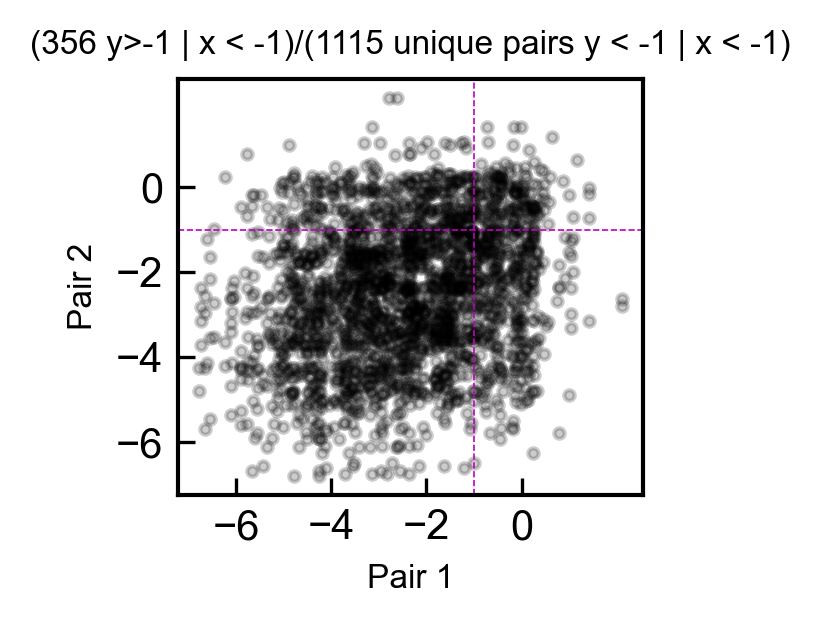

In [81]:
# 4.4 Correlation of signal from overlapping deletions

pairx, pairy = [], []
for k1 in clean_essential_oligos: # for each clean oligo
    for k2 in set(eval(map_meta[k1][header.index("overlapping_oligos")-1])) & set(clean_essential_oligos): # take all overlaps of clean essential oligos
        pairx.append(map_l2fc[k1])
        pairy.append(map_l2fc[k2])

pairx, pairy = NP.array(pairx), NP.array(pairy)
N1 = sum((pairx < -1)&(pairy > -1)) # x is strong; y is weak
N0 = sum((pairx < -1) & (pairy < -1))//2 # number of _pairs_ with both <-1

PL.figure(None, [2,1.8])
PL.plot(pairx, pairy, ".", alpha=0.2)
PL.xlabel("Pair 1"); PL.ylabel("Pair 2")
PL.axhline(-1, linestyle='dashed', linewidth=0.4, color='m')
PL.axvline(-1, linestyle='dashed', linewidth=0.4, color='m')
PL.title(f"({N1} y>-1 | x < -1)/({N0+N1} unique pairs y < -1 | x < -1)")
PL.xticks([-6,-4,-2,0]); PL.yticks([-6,-4,-2,0])
PL.savefig("overlap_consistency.svg")
PL.savefig("overlap_consistency.png", dpi=300)
print(f"If a deletion was depleted, {int(100*N0/(N0+N1))}% of other deletions that overlapped it were depleted ({N0}/{N0+N1} possible pairs concordant; Figure S8)")

/var/folders/y8/l_xfbt0d4kzdvrhkpr5f22mw0000gn/T/ipykernel_18129/1801390257.py:10: RuntimeWarning: divide by zero encountered in log2
  xs["RNAseq_HAP1_mean_expr"] = NP.array(NP.log2(xs["RNAseq_HAP1_mean_expr"]))


The false negatives (deletions of essential gene exons not dropping out) could not be explained by their size, RNA expression from the gene
PRIDICT2 score, DeepCas9 score (maximum Pearson’s |R| with LFC of 0.18, Figure S8)


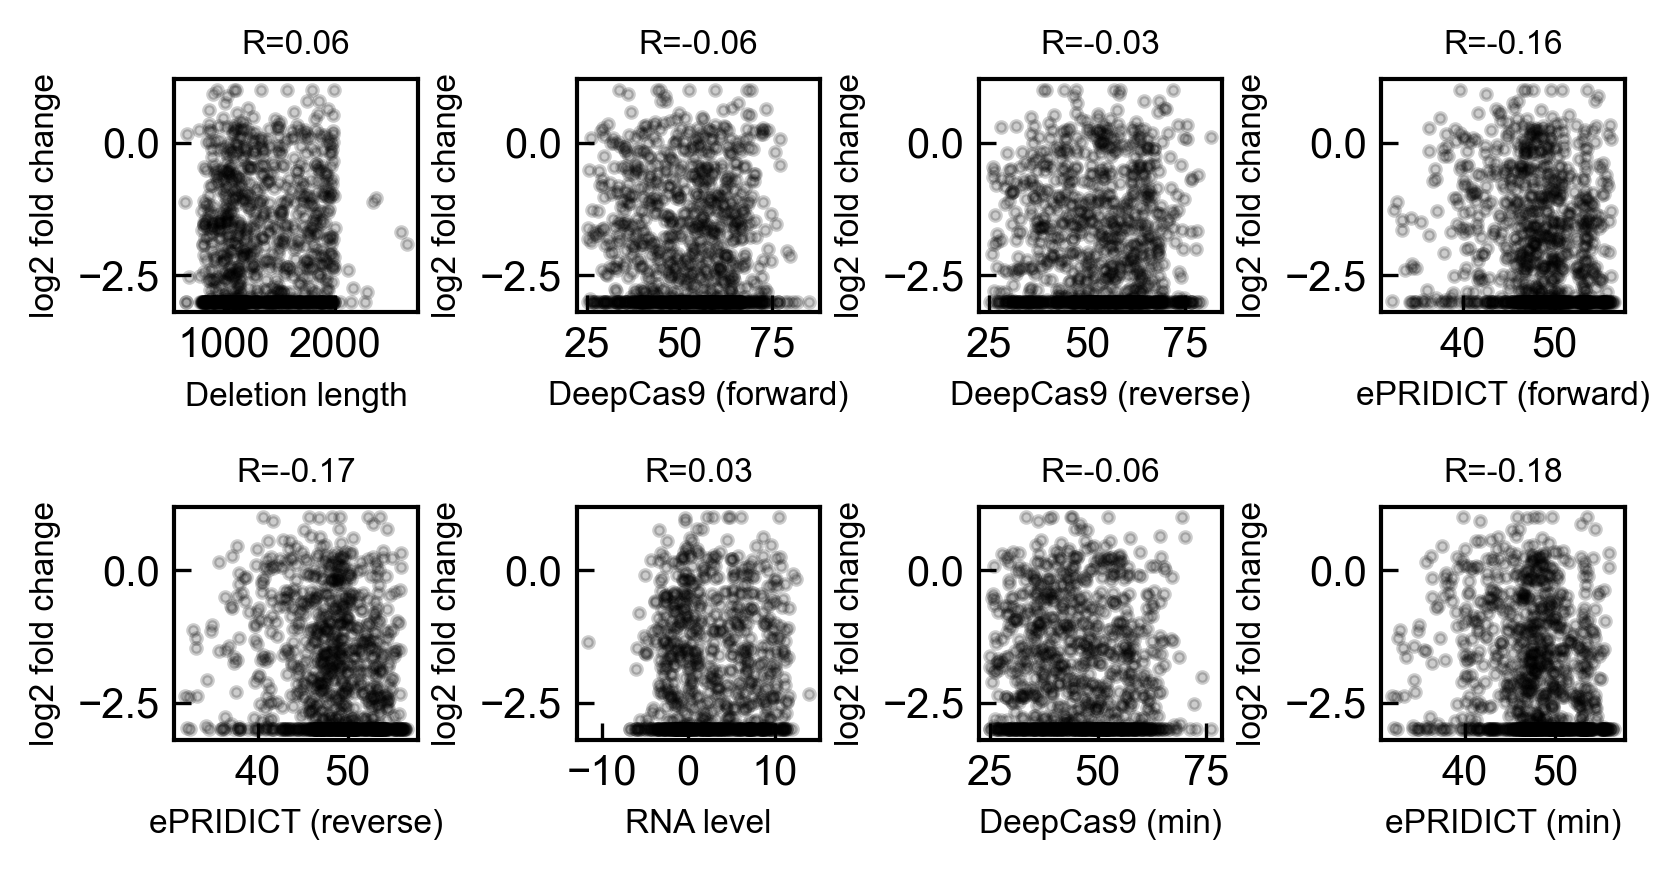

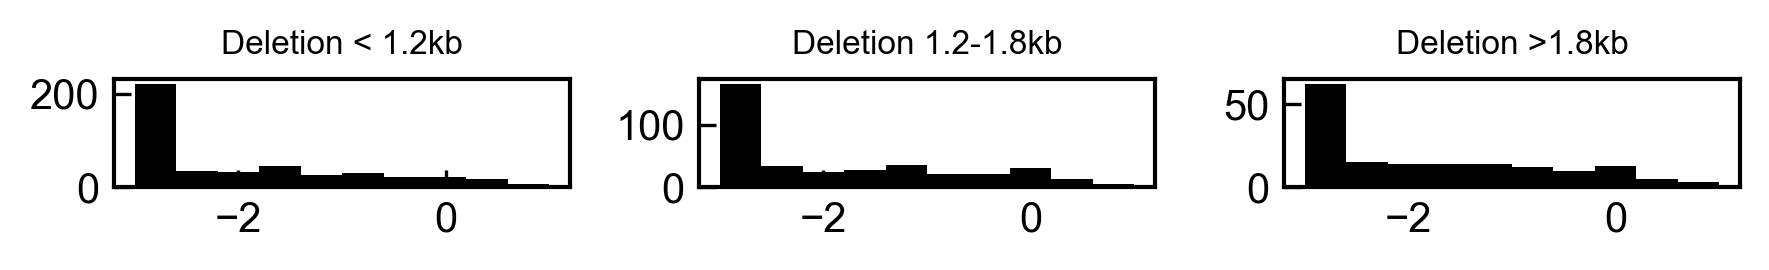

In [80]:
# 4.5 LFC correlates with deletion length, prediction scores, RNA
cols = ["del_length", "deepcas9_for","deepcas9_rev","ePRIDICT_score_for","ePRIDICT_score_rev", "RNAseq_HAP1_mean_expr"]
y = NP.array([min(1, max(-3, map_l2fc[k])) for k in clean_essential_oligos])
xs = {}
for col in cols: xs[col] = NP.array([map_meta[k][header.index(col)-1] for k in clean_essential_oligos], float)
x1,x2 = xs["deepcas9_for"], xs["deepcas9_rev"]
xs["deepcas9_min"] = NP.array([min(x1[i], x2[i]) for i in range(len(x1))])
x1,x2 = xs["ePRIDICT_score_for"], xs["ePRIDICT_score_rev"]
xs["ePRIDICT_score_min"] = NP.array([min(x1[i], x2[i]) for i in range(len(x1))])
xs["RNAseq_HAP1_mean_expr"] = NP.array(NP.log2(xs["RNAseq_HAP1_mean_expr"]))
cols.extend(["deepcas9_min","ePRIDICT_score_min"])
colnames = {
    "del_length": "Deletion length", 
    "deepcas9_for": "DeepCas9 (forward)",
    "deepcas9_rev": "DeepCas9 (reverse)",
    "ePRIDICT_score_for": "ePRIDICT (forward)",
    "ePRIDICT_score_rev": "ePRIDICT (reverse)",
    "deepcas9_min": "DeepCas9 (min)",
    "ePRIDICT_score_min": "ePRIDICT (min)", 
    "RNAseq_HAP1_mean_expr": "RNA level",
    "lib_freq": "Library frequency"
}

PL.figure(None, [5.5,3])
pi = 1
max_r = 0.0
for col in cols:
    PL.subplot(2,4,pi); pi += 1
    PL.plot(xs[col], y,".", alpha=0.2)
    I = NP.isnan(xs[col]) | NP.isnan(y) | NP.isinf(xs[col])
    r = NP.corrcoef(xs[col][~I],y[~I])[0,1]
    max_r = max(abs(r), max_r)
    PL.xlabel(colnames[col]); PL.ylabel("log2 fold change"); PL.title("R=%.2f"%(r))
PL.savefig("LFC_correlates.svg")
PL.savefig("LFC_correlates.png", dpi=300)
PL.tight_layout()

PL.figure(None, [6,1])
x = xs[cols[0]] # deletion length
PL.subplot(131)
PL.hist(y[x < 1200])
PL.title("Deletion < 1.2kb")
PL.subplot(132)
PL.hist(y[(x >= 1200) & (x<1800)])
PL.title("Deletion 1.2-1.8kb")
PL.subplot(133)
PL.hist(y[(x >= 1800)])
PL.title("Deletion >1.8kb")
PL.tight_layout()


print(f"The false negatives (deletions of essential gene exons not dropping out) could not be explained by their size, RNA expression from the gene")
print(f"PRIDICT2 score, DeepCas9 score (maximum Pearson’s |R| with LFC of {max_r:.2}, Figure S8)")


Frame retention: mean LFC=-1.93 Fraction hits=0.69 N=369
Frame disruption: mean LFC=-2.35 Fraction hits=0.74 N=630
or coding frame disruption (fraction of dropouts 0.69 vs 0.74 for frame preserving deletions vs not).


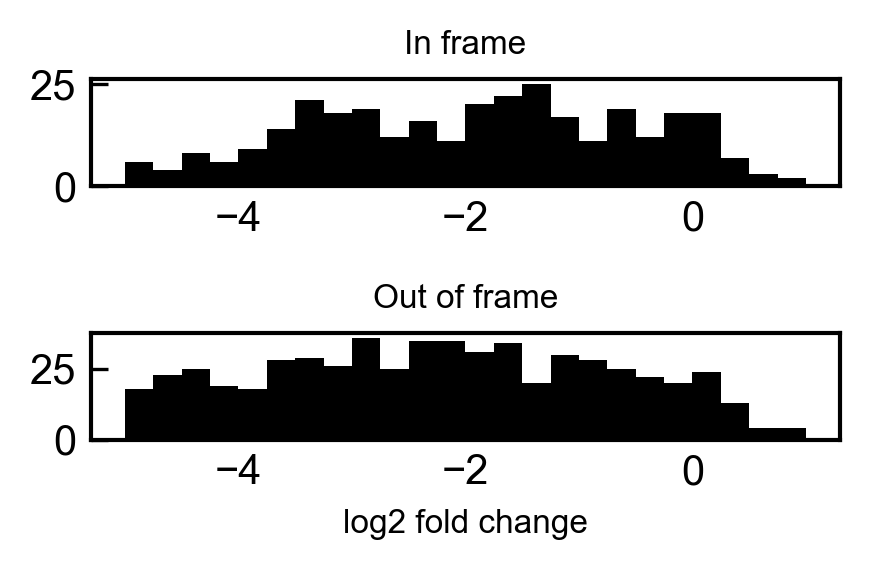

In [68]:
# 4.6 LFC link to frame preservation
coding_deletion_length = compute_coding_length(header, map_gene, exons, map_meta)
xs, ys = [], []
for k in set(clean_essential_oligos):
    if k in coding_deletion_length and coding_deletion_length[k] > 0:
        xs.append(coding_deletion_length[k])
        ys.append(map_l2fc[k])

I = (NP.array(xs) % 3) == 0 # In frame
ys = NP.array(ys)
dropouts_inframe = 1.*sum(ys[I]<-1)/sum(I)
dropouts_noframe = 1.*sum(ys[~I]<-1)/sum(~I)
PL.figure(None, [3,2])
PL.subplot(211)
PL.hist(ys[I], range=(-5,1), bins=24)
print(f"Frame retention: mean LFC={NP.nanmedian(ys[I]):.2f} Fraction hits={1.*sum(ys[I] < -1)/len(ys[I]):.2f} N={sum(I)}")
PL.title("In frame")
PL.subplot(212)
PL.hist(ys[~I], range=(-5,1), bins=24)
print(f"Frame disruption: mean LFC={NP.nanmedian(ys[~I]):.2f} Fraction hits={1.*sum(ys[~I] < -1)/len(ys[~I]):.2f} N={sum(~I)}")
PL.xlabel("log2 fold change"); PL.title("Out of frame")
PL.tight_layout()

print(f"or coding frame disruption (fraction of dropouts {dropouts_inframe:.2} vs {dropouts_noframe:.2} for frame preserving deletions vs not).")

TRRAP frame retention: mean LFC=0.19 Fraction hits=0.18 N=11
TRRAP frameshift: mean LFC=-0.53 Fraction hits=0.29 N=21
MannwhitneyuResult(statistic=143.0, pvalue=0.1420281891540261)


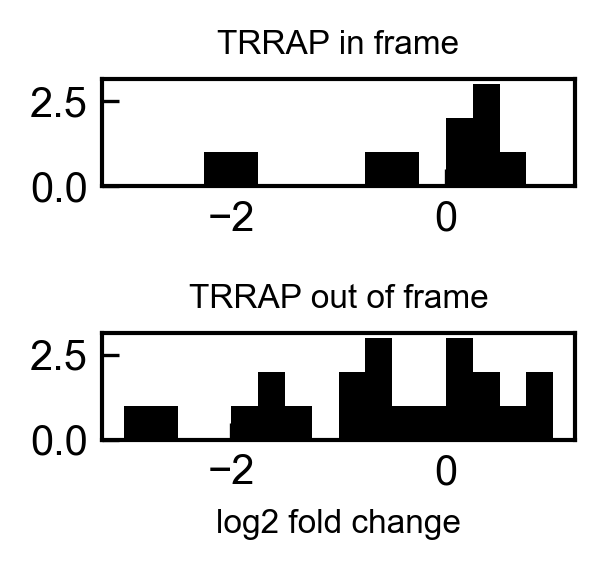

In [70]:
# 4.6 TRRAP contrast for in and out of frame
xs, ys = [coding_deletion_length[k] for k in all_dels["TRRAP"]["Coding"]], [map_l2fc[k] for k in all_dels["TRRAP"]["Coding"]]
PL.figure(None, [2,2])
I = (NP.array(xs) % 3) == 0
ys = NP.array(ys)
PL.subplot(211)
PL.hist(ys[I], range=(-3,1), bins=16)
print(f"TRRAP frame retention: mean LFC={NP.nanmedian(ys[I]):.2f} Fraction hits={1.*sum(ys[I] < -1)/len(ys[I]):.2f} N={sum(I)}")
PL.title("TRRAP in frame")
PL.subplot(212)
PL.hist(ys[~I], range=(-3,1), bins=16)
PL.xlabel("log2 fold change"); PL.title("TRRAP out of frame")
print(f"TRRAP frameshift: mean LFC={NP.nanmedian(ys[~I]):.2f} Fraction hits={1.*sum(ys[~I] < -1)/len(ys[~I]):.2f} N={sum(~I)}")
from scipy.stats import mannwhitneyu
print(mannwhitneyu(ys[I], ys[~I], alternative="greater"))
PL.tight_layout()

In [71]:
# 5.1 List total number of non-coding signals
N = {}
for gene in all_lfcs:
    for del_type in all_lfcs[gene]:
        if del_type == "Coding": continue
        if del_type not in N: N[del_type] = 0
        N[del_type] += sum(NP.array(all_lfcs[gene][del_type]) < -1)
for del_type in N:
    print(f"{del_type}: {N[del_type]}")
print(f"We next explored the {sum(N.values())} deletions outside coding exons with strong signal (LFC < -1). ")

Intronic: 77
3'UTR: 124
5'UTR: 166
Other: 95
We next explored the 462 deletions outside coding exons with strong signal (LFC < -1). 


CRISPR essential
	Coding   	N=1003	Hits = 724	frac=0.72
	Intronic 	N=434	Hits = 57	frac=0.13
	3'UTR    	N=294	Hits = 93	frac=0.32
	5'UTR    	N=202	Hits = 128	frac=0.63
	Other    	N=1122	Hits = 53	frac=0.047

Observed essential
	Coding   	N=978	Hits = 753	frac=0.77
	Intronic 	N=418	Hits = 61	frac=0.15
	3'UTR    	N=304	Hits = 96	frac=0.32
	5'UTR    	N=220	Hits = 135	frac=0.61
	Other    	N=1098	Hits = 56	frac=0.051

All
	Coding   	N=2064	Hits = 825	frac=0.4
	Intronic 	N=1085	Hits = 74	frac=0.068
	3'UTR    	N=683	Hits = 121	frac=0.18
	5'UTR    	N=530	Hits = 153	frac=0.29
	Other    	N=2710	Hits = 80	frac=0.03



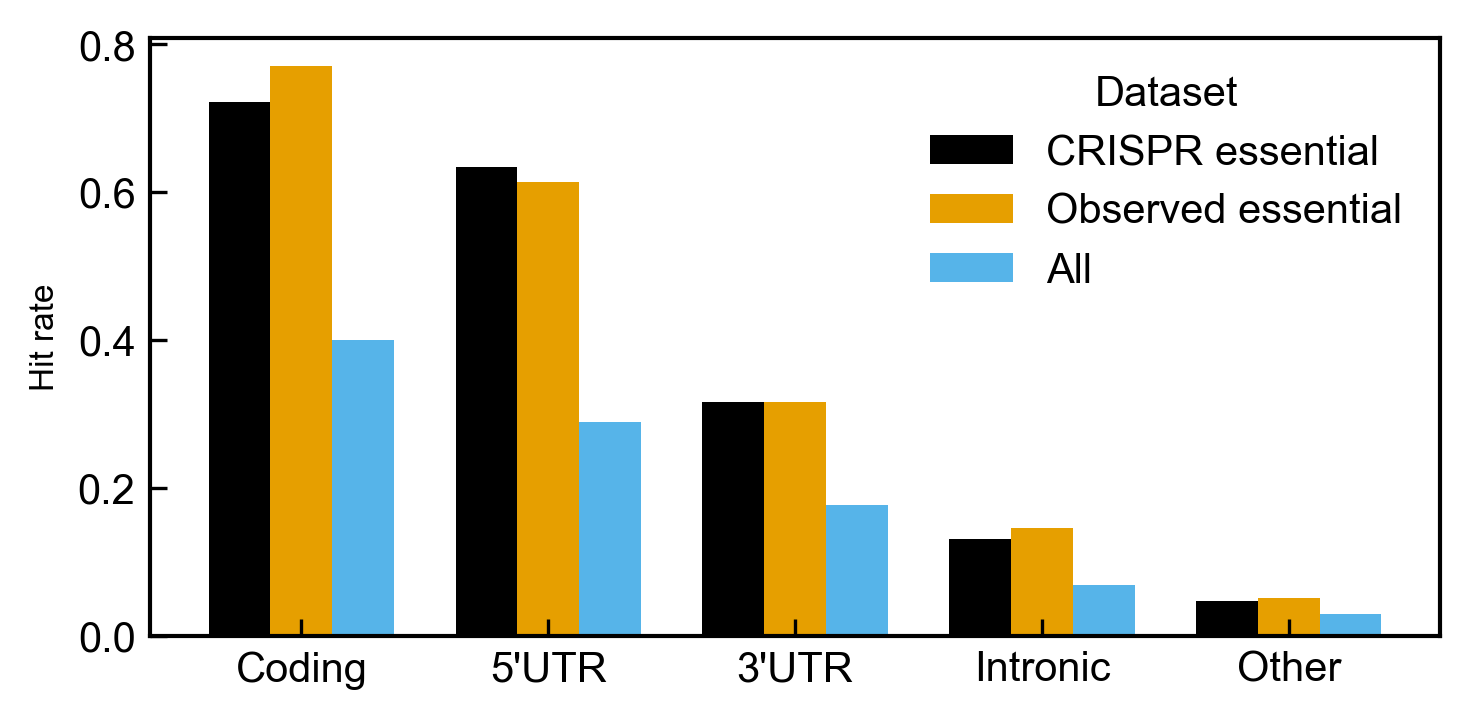

In 5’UTR exons, 63% (128/202) of deletions dropped out, followed by 31% (93/294) in the 3’UTR, 13% (57/434) in introns, and 5% (53/1122) in other regions, in contrast to 72% of coding region deletions (Figure 5d).


In [82]:
# 5.2 List enrichments in exons/UTRs/introns/other
genesets = {"CRISPR essential":essential_genes, "Observed essential": [gene for gene in all_lfcs if NP.nanmedian(all_lfcs[gene]["Coding"]) <= -1], "All":list(all_lfcs.keys())}
vals = {}
for g in genesets:
    geneset = genesets[g]
    print(g)
    vals[g] = {}
    for del_type in list(all_lfcs.values())[0]:
        type_dels = []
        for gene in geneset:
            type_dels.extend(all_dels[gene][del_type])
        all_vals = NP.array([map_l2fc[oligo] for oligo in set(type_dels)])
        print(f"\t{del_type:9}\tN={len(all_vals)}\tHits = {sum(all_vals < -1)}\tfrac={1.*sum(all_vals < -1)/len(all_vals):.2}")
        vals[g][del_type] = 1.*sum(all_vals < -1)/len(all_vals)
    print()


# Arrange bar positions
width = 0.25                  # width of each bar
offsets = NP.linspace(-width, width, len(vals))
fig, ax = PL.subplots(figsize=(5, 2.5))

# Plot bars
measures = ["Coding", "5'UTR", "3'UTR", "Intronic", "Other"]
for i, dataset in enumerate(vals):
    ax.bar(NP.arange(len(measures)) + offsets[i], [vals[dataset][m] for m in measures], width=width, label=dataset)

# Style plot
ax.set_xticks(NP.arange(len(measures))); ax.set_xticklabels(measures)
ax.set_ylabel("Hit rate")
ax.legend(title="Dataset")
PL.tight_layout()
PL.savefig("region_hit_rates.svg")
PL.savefig("region_hit_rates.png", dpi=300)
PL.show()


N, N1, f = {}, {}, {}
for m in measures:
    v = []
    for gene in essential_genes:
        v.extend(all_lfcs[gene][m])
    v = NP.array(v)
    N[m] = len(v)
    N1[m] = sum(v < -1)
    f[m] = 1.*sum(v < -1)/len(v)
p, n1, n = int(100*f["5'UTR"]), N1["5'UTR"], N["5'UTR"]
print(f"In 5’UTR exons, {p}% ({n1}/{n}) of deletions dropped out, ", end="")
p, n1, n = int(100*f["3'UTR"]), N1["3'UTR"], N["3'UTR"]
print(f"followed by {p}% ({n1}/{n}) in the 3’UTR, ", end="")
p, n1, n = int(100*f["Intronic"]), N1["Intronic"], N["Intronic"]
print(f"13% (57/434) in introns, ", end="")
p, n1, n = int(100*f["Other"]), N1["Other"], N["Other"]
print(f"and 5% (53/1122) in other regions, ", end="")
p = int(100*f["Other"])
print(f"in contrast to 72% of coding region deletions (Figure 5d).")

/var/folders/y8/l_xfbt0d4kzdvrhkpr5f22mw0000gn/T/ipykernel_18129/864854034.py:32: RuntimeWarning: All-NaN slice encountered
  oligo_expr = NP.nanmax(get_rnaseq_coverage(mm[2], int(x1), int(x2), do_normalize=False))


None                    	: 0.05 (Hits=39 / Total overlap=743)
Distal enhancer         	: 0.13 (Hits=83 / Total overlap=621)
Proximal enhancer       	: 0.34 (Hits=181 / Total overlap=530)
Within 25nt of exon     	: 0.37 (Hits=11 / Total overlap=30)
Promoter                	: 0.50 (Hits=135 / Total overlap=269)
Transcribed non-coding  	: 0.61 (Hits=158 / Total overlap=261)
CADD-SV Raw score > 0.31	: 0.35 (Hits=252 / Total overlap=718)
Total oligos considered=1995, fraction depleted=0.17 (346)


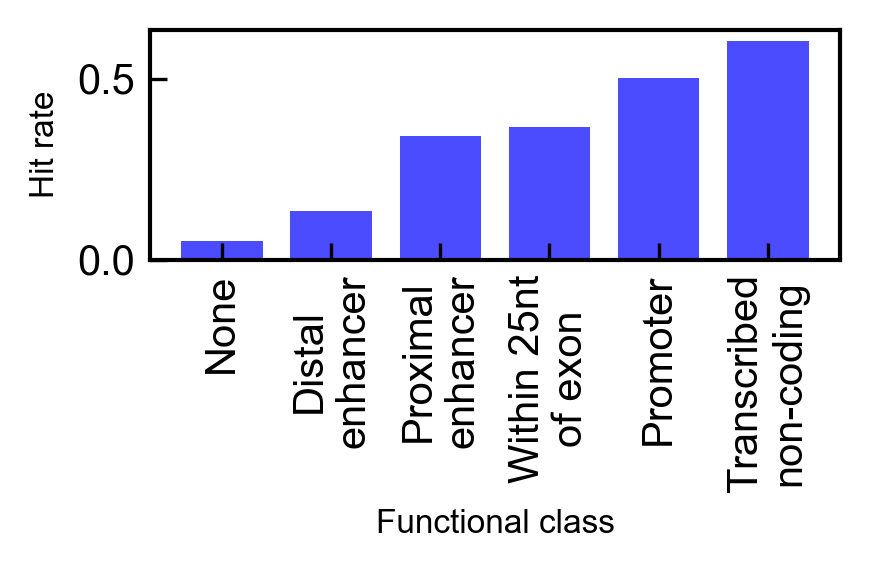

In [101]:
# 5.3 List and plot non-coding functional enrichments

# List all non-exonic strong signals for clean genes
def print_track_overlaps(map_meta, map_l2fc, all_dels, gene_decorations, measures, names, cutoff=-1):
    overlaps = {}# track: [] for track in list(gene_decorations.values())[0]}
    overlaps["any"] = []
    overlaps["none"] = []
    overlaps["splice"] = []
    overlaps["mirna"] = []
    overlaps["transcribed"] = []
    overlaps["pELS"] = []
    overlaps["PLS"] = []
    overlaps["dELS"] = []
    overlaps["DNase-H3K4me3"] = []
    overlaps["CTCF-only"] = []
    overlaps["CADD-SV_Raw-score > 0.31"] = []
    exoverlaps = {track: [] for track in overlaps}
    done_oligos = {}

    for gene in all_dels:
        gene_exons = get_gene_exons(gene,exons)
        if NP.nanmedian(all_lfcs[gene]["Coding"]) > -1 or len(all_lfcs[gene]["Coding"]) < 3: continue

        for del_type in all_dels[gene]:
            if del_type == "Coding": continue # want everything but coding
            for o in all_dels[gene][del_type]:
                if NP.isnan(map_l2fc[o]) or o in done_oligos:
                    continue
                done_oligos[o] = True
                mm = NP.array(map_meta[o])
                x1, x2 = float(mm[0]), float(mm[1])
                oligo_expr = NP.nanmax(get_rnaseq_coverage(mm[2], int(x1), int(x2), do_normalize=False))
                max_expr = get_max_expr(mm[2], get_gene_exons(gene, exons, "00")+get_gene_exons(gene, exons, "10")+get_gene_exons(gene, exons, "01"))

                oligo_does_overlap = {}
                if max_expr - oligo_expr < NP.log2(3): oligo_does_overlap["transcribed"] = True
                splice_span = 25
                gene_decorations[gene][f"splice"] = get_exon_splice_regions(gene_exons, mm[5], splice_span, splice_span) # exons and strand

                for track in gene_decorations[gene]:
                    for (s, e) in gene_decorations[gene][track]:
                        if does_overlap((x1,x2), (s,e)):
                            oligo_does_overlap[track] = True

                for track in oligo_does_overlap:
                    if track not in overlaps: continue
                    overlaps[track].append(map_l2fc[o])
                overlaps["any"].append(map_l2fc[o])

                strongest_track = "none"
                for track in ["any", "DNase-H3K4me3", "CTCF-only", "dELS", "mirna", "splice", "pELS", "PLS", "transcribed"]:
                    if track in oligo_does_overlap:
                        strongest_track = track
                exoverlaps[strongest_track].append(map_l2fc[o])

                if len(oligo_does_overlap) == 0: 
                    overlaps["none"].append(map_l2fc[o])
                cadd = float(mm[header.index("CADD-SV_Raw-score")-1])
                if cadd > 0.31:
                    overlaps["CADD-SV_Raw-score > 0.31"].append(map_l2fc[o])
    rates = {}
    names = {n.replace("\n", " "):names[n] for n in names}
    for track in measures: #track in overlaps:
        vs = NP.array(overlaps[track])
        print(f"{names[track]:24}\t: {1.*sum(vs<cutoff)/(1e-4+len(vs)):.2f} (Hits={sum(vs < cutoff)} / Total overlap={len(vs)})")
        rates[track] = 1.*sum(vs<cutoff)/(1e-4+len(vs))
    n_depleted = sum([map_l2fc[o] < cutoff for o in done_oligos])
    frac_depleted = 1.*n_depleted/len(done_oligos)
    print(f"Total oligos considered={len(done_oligos)}, fraction depleted={frac_depleted:.2} ({n_depleted})")
    return rates

measures = ["none", "dELS", "pELS", "splice", "PLS", "transcribed", "CADD-SV_Raw-score > 0.31"]
names = {"none":"None", "dELS": "Distal enhancer", "mirna": "miRNA", "splice": "Within 25nt of exon", "pELS":"Proximal enhancer", "PLS":"Promoter", "transcribed": "Transcribed non-coding", "CADD-SV_Raw-score > 0.31":"CADD-SV Raw score > 0.31"}
gene_decorations = get_gene_decorations(get_gene_areas(map_meta, all_dels, header), read_regulatory_locations())
func_rates = print_track_overlaps(map_meta, map_l2fc, all_dels, gene_decorations, measures, names, cutoff=-1)


# Plot bars
measures = ["none", "dELS", "pELS", "splice", "PLS", "transcribed"]
names = {"none":"None", "dELS": "Distal\nenhancer", "mirna": "miRNA", "splice": "Within 25nt\nof exon", "pELS":"Proximal\nenhancer", "PLS":"Promoter", "transcribed": "Transcribed\nnon-coding"}
x = NP.arange(len(measures))  # positions for measure groups
width = 0.25                  # width of each bar
offsets = NP.linspace(-width, width, 2)
fig, ax = PL.subplots(figsize=(3, 2))
values = [func_rates[m] for m in measures]    
ax.bar(x, values, width=0.75, color='b', alpha=0.7)
ax.set_xticks(x)
ax.set_xticklabels([names[m] for m in measures], rotation=90)
ax.set_ylabel("Hit rate")
ax.set_xlabel("Functional class")
PL.tight_layout()
PL.savefig("functional_enrichment.svg")
PL.savefig("functional_enrichment.png", dpi=300)
PL.show()

Intronic deletions had a larger impact when closer to splice junctions (Figure 5f), with all
4/4 deletions within 3nt of a junction and 5/9 within 10nt depleting


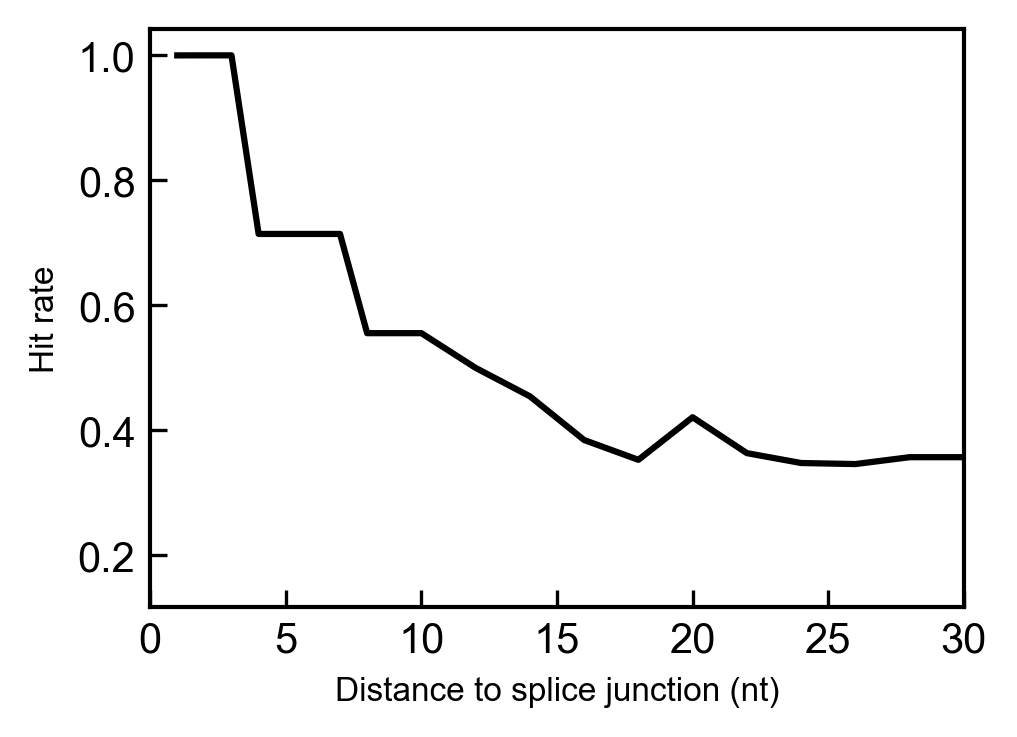

In [104]:
# 5.4 Signal range around splice sites

# List all non-exonic strong signals for clean genes
def print_track_overlaps(map_meta, map_l2fc, all_dels, cutoff=-1):
    overlaps = {}# track: [] for track in list(gene_decorations.values())[0]}
    done_oligos = {}

    for gene in all_dels:
        splice_regions = {}
        gene_exons = get_gene_exons(gene,exons)
        if NP.nanmedian(all_lfcs[gene]["Coding"]) > -1 or len(all_lfcs[gene]["Coding"]) < 3: continue

        for del_type in all_dels[gene]:
            if del_type != "Intronic": continue # want everything but coding
            for o in all_dels[gene][del_type]:
                if NP.isnan(map_l2fc[o]) or o in done_oligos:
                    continue
                done_oligos[o] = True
                mm = NP.array(map_meta[o])
                x1, x2 = float(mm[0]), float(mm[1])

                oligo_does_overlap = {}
                for span in list(range(1,10))+list(range(10,30,2)) + list(range(30,60,6)) + list(range(60, 100, 8)) + list(range(100,400,20)) + list(range(400,1500,100)):
                    splice_regions[span] = get_exon_splice_regions(gene_exons, mm[5], span, span) # exons and strand
                    if span not in overlaps: overlaps[span] = []

                for track in splice_regions:
                    for (s, e) in splice_regions[track]:
                        if does_overlap((x1,x2), (s,e)):
                            oligo_does_overlap[track] = True

                for track in oligo_does_overlap:
                    if track not in overlaps: continue
                    overlaps[track].append(map_l2fc[o])
    rates, hits = {}, {}
    for track in overlaps:
        vs = NP.array(overlaps[track])
        #print(f"{track}\t: {1.*sum(vs<cutoff)/(1e-4+len(vs)):.2f} (Hits={sum(vs < cutoff)} / Total overlap={len(vs)})")
        rates[track] = 1.*sum(vs<cutoff)/(1e-4+len(vs))
        hits[track] = sum(vs<cutoff)
    return rates, hits

splice_rates, splice_hits = print_track_overlaps(map_meta, map_l2fc, all_dels, cutoff=-1)

PL.figure()
xs, ys = [t for t in sorted(splice_rates)], [splice_rates[t] for t in sorted(splice_rates)]
PL.plot(xs,ys)
PL.ylabel("Hit rate")
PL.xlabel("Distance to splice junction (nt)")
PL.xlim(0,30)
PL.savefig("splice_signal.svg")
PL.savefig("splice_signal.png", dpi=300)

print(f"Intronic deletions had a larger impact when closer to splice junctions (Figure 5f), with all")
print(f"{splice_hits[3]}/{int(1.*splice_hits[3]/splice_rates[3])} deletions within 3nt of a junction and {splice_hits[10]}/{int(1.*splice_hits[10]/splice_rates[10])} within 10nt depleting")
